In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [2]:
experiment_results = os.path.join('..','data', 'input', '4a_FS.xlsx')
result_df = pd.read_excel(experiment_results)
result_df = result_df.drop(['Status','promptOrder','What was your strategy for sorting?','answer code'],axis=1)
result_df.head()

,Reference #,SubNum,condOrder,targetOrder,rawLog,Age:,Nationality:,Sex:,Date,User
0,1871343,4113,"3,0,1,2,3","3,1,2","62,1,3:44,2,3:77,3,3:26,3,3:35,2,3:39,1,3:67,2...",31,Mexican,male,2014-12-05 22:26:57,189.153.101.116
1,1871209,6311,"1,2,3,0,1","2,1,3","11,1,1:8,3,1:60,2,1:9,1,1:57,3,1:67,1,1:48,1,1...",25,Bosnia and Herzegovina,male,2014-12-05 21:58:13,46.36.160.194
2,1871202,5410,"0,1,2,3,0","1,3,2","29,2,0:49,3,0:34,2,0:40,2,0:52,2,0:17,1,0:55,3...",43,Mexican,male,2014-12-05 21:56:04,187.142.106.38
3,1870894,7212,"2,3,0,1,2","1,2,3","35,2,2:4,1,2:25,3,2:39,1,2:14,2,2:51,3,2:32,2,...",31,USA,male,2014-12-05 20:51:37,70.15.32.175
4,1870884,6721,"2,1,0,3,2","2,1,3","7,1,2:65,1,2:57,3,2:39,2,2:28,1,2:79,3,2:9,1,2...",25,Spanish,male,2014-12-05 20:50:32,79.146.44.157


In [3]:
def make_path(p):
    if not os.path.exists(p):
        os.makedirs(p)

In [4]:
with open('../data/input/conditions.txt', "r") as file:
    conditions_json = json.load(file)

card_codes_text = open('../data/input/cards_codes.txt', "r")
card_codes = [[int(i) for i in line.strip().split(',')] for line in card_codes_text]
pile_codes = [[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]]

# Convert Original dataset to the Model's format 

In [5]:
subject_evaluation = []
subject_tries = []
dead_list = []

out_columns = ['trial', 'card', 'demanded_criterion', 'selected_pile', 'feedback', 'total_streaks']
out_path = os.path.join('..','data','output', 'original_formatted')
make_path(out_path)
for subject, row in result_df.iterrows():
    tries_list = []
    rows = []
    
    # print('--------------------------')
    # print(f"Subject {subject}:\n")
    streak = 0
    total_streaks = 0
    streak_begin = None
    streak_end = None
    crit_index = 0
    
    log = row.rawLog.split(":")[0:-1]
    # criterion_order = [int(i) for i in row.condOrder.split(",")]
    # pile_order = [int(i) for i in row.targetOrder.split(",")]
    
    for i, trial in enumerate(log):
        # Trial's log: First item shows the Card number, Second selected pile and Third, the demanded Criterion. 
        t_log = trial.split(",")
      
        card_number = int(t_log[0])
        card = card_codes[card_number-1]
        
        selected_pile = int(t_log[1])
        pile = pile_codes[selected_pile-1]
        demanded_criterion = int(t_log[2])
        
        if card[demanded_criterion] == pile[demanded_criterion]:
            result = True
            streak += 1
        else:
            result = False
            streak = 0
        row = [i+1, card, demanded_criterion, selected_pile, result]      
        
        if streak == 10:
            total_streaks += 1
            streak_begin = i -9
            row.append(total_streaks)
            if total_streaks == 1:
                tries = streak_begin
            else:
                tries = streak_begin - (streak_end+1)
            tries_list.append(tries)
            streak_end = i
            # print(f"Streak Began at {streak_begin}")
            # print(f"Took {tries} Tries.")
            if total_streaks < 5:
                post_criterion = int(log[i+1].split(",")[2])
                # print(f"Criterion changed from{demanded_criterion} to {post_criterion}")
            streak = 0
        else: 
            row.append(None)
        rows.append(row)
            
        if total_streaks <= 4:
            if i == len(log)-1:
                if streak_end is not None:
                    tries = i - (streak_end+1)
                else:
                    tries = i
                dead_list.append([subject+1,tries+1])
    out_df = pd.DataFrame(rows, columns=out_columns)
    out_df.to_csv(os.path.join(out_path,f'{subject+1}.csv'), index=False)

    subject_code = f"{subject+1}.{total_streaks}" 
    subject_evaluation.append(total_streaks)
    subject_tries.append(tries_list)
    
print(f"Subject Evaluation: {subject_evaluation}\n")
print(f"Subject Tries: {subject_tries}\n")
print(f"Dead List): {dead_list}\n")


Subject Evaluation: [4, 5, 5, 5, 4, 0, 4, 2, 5, 0, 4, 2, 2, 3, 4, 0, 1, 2, 2, 1, 1, 4, 3, 2, 5, 5, 1, 5, 2, 2, 3, 3, 3, 3, 5, 3, 3, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5]

Subject Tries: [[56, 18, 5, 8], [12, 46, 32, 3, 7], [2, 9, 17, 42, 9], [12, 59, 12, 5, 7], [12, 41, 10, 34], [], [10, 13, 39, 22], [6, 3], [14, 25, 13, 6, 2], [], [30, 11, 49, 19], [2, 39], [0, 2], [34, 19, 1], [20, 7, 3, 65], [], [20], [95, 17], [37, 80], [4], [3], [1, 74, 2, 2], [70, 19, 4], [53, 27], [7, 6, 7, 76, 3], [29, 9, 5, 48, 9], [32], [12, 12, 11, 3, 6], [19, 17], [7, 11], [3, 30, 6], [0, 2, 8], [0, 4, 5], [28, 85, 8], [4, 51, 4, 8, 4], [5, 14, 10], [0, 72, 2], [6, 3], [20, 8], [13, 10, 11, 18, 7], [5, 24, 8, 3, 7], [0, 16, 5, 1, 14], [10, 7, 8, 7, 2], [1, 5, 13, 6, 3], [7, 1, 36, 2, 4], [1, 11, 1, 12, 3], [2, 3, 16, 2, 6]]

Dead List): [[1, 29], [5, 19], [6, 156], [7, 32], [8, 127], [10, 156], [11, 7], [12, 95], [13, 134], [14, 72], [15, 21], [16, 156], [17, 126], [18, 24], [19, 19], [20, 142], [21, 143], [22, 37]

# Visualization

In [6]:
df = pd.DataFrame({'freq': subject_evaluation})
df.head()

,freq
0,4
1,5
2,5
3,5
4,4


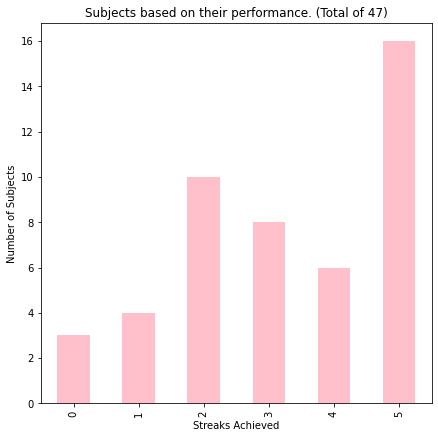

In [7]:
ax = df.groupby('freq', as_index=False).size().plot(kind='bar',figsize=(7,7),
                title=f"Subjects based on their performance. (Total of {len(subject_tries)})", color='pink')
ax.set_xlabel("Streaks Achieved")
ax.set_ylabel("Number of Subjects")
plt.show()

# Calculating The Average RMSE 

In [8]:
def RMSE(p, t, print_result=False):
    # Base Results:
    base_results = {
        'start_n': [12, 11, 12, 9],
        'start_mean': [20.75, 12.91, 5.58, 27.33],
        'start_std': [22.59, 9.87, 8.83, 30.49],
        'switch_n': [16, 10, 14, 19, 13, 14, 14, 8],
        'switch_mean': [11.13, 16, 15.29, 11.47, 11.69, 38.71, 6.86, 23.25],
        'switch_std': [8.39, 13.13, 22.06, 13.38, 11.41, 28.18, 6.55, 26.44]
    }
    prediction = np.array(p)
    target = np.array(base_results[t])
    if print_result:
        print(f"Model Results: \n{prediction} \nBase Results: \n{target}\n")

    return np.sqrt(np.mean((prediction - target) ** 2))

In [9]:
mean = np.mean([11.13, 16, 15.29, 11.47, 11.69, 38.71, 6.86, 23.25])
std = np.mean([8.39, 13.13, 22.06, 13.38, 11.41, 28.18, 6.55, 26.44])
RMSE_mean = RMSE([mean,mean,mean,mean,mean,mean,mean,mean],'switch_mean')
RMSE_std = RMSE([std,std,std,std,std,std,std,std],'switch_std')
print(f"Target Mean RMSE on {np.round(mean)}: \n{RMSE_mean}\nTarget STD RMSE on {np.round(std)}: \n{RMSE_std}")

Target Mean RMSE on 17.0: 
9.421015072697847
Target STD RMSE on 16.0: 
7.722994480769748
